In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers 
from tensorflow.keras import Model
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
BUCKET = 10
IMAGE_SIZE = (224, 224)
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 64

In [7]:
gdrive_dir = "/content/drive/MyDrive"
working_dir = os.path.join(gdrive_dir, "CS3244 Project")
data_root_dir = os.path.join(working_dir, "landmarks/international/data_split")
data_dir = os.path.join(data_root_dir, str(BUCKET))
model_root_dir = os.path.join(working_dir, "models/Guojun")

In [39]:
print('number of international labels:', len(os.listdir(data_dir)))

number of international labels: 200


In [8]:
dataflow_kwargs = dict(target_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
                   interpolation="bilinear")

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255, 
    validation_split = VALIDATION_SPLIT,
    rotation_range = 30,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 0.1,
    zoom_range = 0.1,
    brightness_range = [0.9,1.1],
    fill_mode = 'nearest'
)
train_generator = train_datagen.flow_from_directory(
    data_dir,
    subset = "training", 
    shuffle = True, 
    target_size = IMAGE_SIZE ,
    batch_size = BATCH_SIZE,
    class_mode = 'categorical',
)

validation_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split = VALIDATION_SPLIT
)
validation_generator = validation_datagen.flow_from_directory(
    data_dir,
    subset = "validation", 
    shuffle = False, 
    target_size = IMAGE_SIZE,
    batch_size = BATCH_SIZE,
    class_mode = 'categorical'
)

Found 1514 images belonging to 200 classes.
Found 285 images belonging to 200 classes.


In [49]:
mobile_model = MobileNetV2()

In [ ]:
mobile_model.summary()

In [50]:
last_layer = mobile_model.get_layer("predictions")
last_output = last_layer.output

In [ ]:
x = layers.Flatten()(last_output)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(200, activation='softmax')(x)

model = Model(mobile_model.input, x)

In [ ]:
model.summary()

In [9]:
load_model_dir = os.path.join(model_root_dir, "mobilev2_model_i9b")
model = tf.keras.models.load_model(load_model_dir)

In [10]:
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = tf.keras.optimizers.RMSprop(lr=0.001),
    metrics = ['accuracy']
)

steps_per_epoch = int(train_generator.samples / BATCH_SIZE)
validation_steps = int(validation_generator.samples / BATCH_SIZE)

print("Steps per epoch:", steps_per_epoch)
print("Validation steps:", validation_steps)

Steps per epoch: 23
Validation steps: 4


In [11]:
history = model.fit(
    train_generator,
    steps_per_epoch = steps_per_epoch,
    epochs = 30,
    validation_data = validation_generator,
    validation_steps = validation_steps
)

save_model_dir = os.path.join(model_root_dir, "mobilev2_model_i10b")
model.save(save_model_dir)

Epoch 1/30
23/23 [==============================] - 761s 32s/step - loss: 6.4616 - accuracy: 0.0198 - val_loss: 19.8647 - val_accuracy: 0.0117
Epoch 2/30
23/23 [==============================] - 55s 2s/step - loss: 4.5408 - accuracy: 0.1227 - val_loss: 19.2421 - val_accuracy: 0.0469
Epoch 3/30
23/23 [==============================] - 54s 2s/step - loss: 3.9018 - accuracy: 0.2580 - val_loss: 15.6811 - val_accuracy: 0.0586
Epoch 4/30
23/23 [==============================] - 54s 2s/step - loss: 3.5160 - accuracy: 0.3207 - val_loss: 18.1811 - val_accuracy: 0.0430
Epoch 5/30
23/23 [==============================] - 54s 2s/step - loss: 3.3425 - accuracy: 0.3571 - val_loss: 15.8628 - val_accuracy: 0.0430
Epoch 6/30
23/23 [==============================] - 54s 2s/step - loss: 3.0324 - accuracy: 0.3681 - val_loss: 13.2192 - val_accuracy: 0.0430
Epoch 7/30
23/23 [==============================] - 54s 2s/step - loss: 2.7890 - accuracy: 0.4135 - val_loss: 12.5050 - val_accuracy: 0.0586
Epoch 8/30


<Figure size 432x288 with 0 Axes>

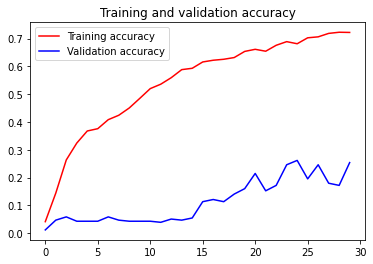

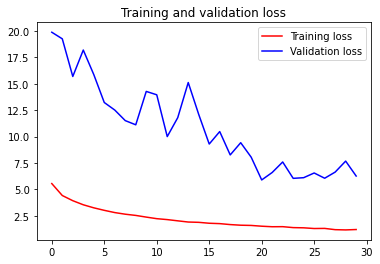

<Figure size 432x288 with 0 Axes>

In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()